In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve


In [5]:

def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0
    

In [6]:
def biphasic_alpha(t,tauOPL,tauOPL2,SF):
    
    kern =  (t/tauOPL**2) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2**2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = (t/tauOPL) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = kern/(np.sum(kern)*0.001)
    #calculate integral
    return  kern


tauOPLmono = 0.04
tauOPL = 0.08
tauOPL2 = 0.0876
SF = 1.

ftime = np.arange(0,1,0.001)
filter_mono = biphasic_alpha(ftime,tauOPLmono,1,0)
filter_mono = filter_mono/filter_mono.max()
filter_bi = biphasic_alpha(ftime,tauOPL,tauOPL2,SF)
filter_bi = filter_bi/filter_bi.max()


In [7]:

speeds = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0])


In [8]:
data = {}
cell = 150


nets_list = ['Loops/fb_thesis_linear/wAB/wAB_0.0',
             'Loops/fb_thesis_linear/wAB/wAB_46.0' ]




for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    RBs = []
    RAs = []
    RGs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []
    ants_drive = []

    for s in speeds: 
        fp = f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/smooth_{s}'
        with open(f'{fp}/out', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        pos_cell = paramsi['pos_rf_GC_mid'][cell]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['F'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['F'][:])

        


        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG
    
        ant_drive =  tp_bar - peak_drive

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['F'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        RGs.append(out['RG'])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)
        ants_drive.append(ant_drive)


    
    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)  

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    data[net]['ants']['drive'] =np.asarray(ants_drive)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['F'] = Fs


    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times

In [9]:
def normalize(vals):
    vals = np.asarray(vals)
    return (vals-np.mean(vals))/np.std(vals)


In [10]:
speeds_plot = [0.1,0.5,1.0]
speeds_plot_idx = [0,4,-2]
xlims = [(2,12),(1.2,3),(0.2,0.75)]

# Figure Parameter

In [11]:
%matplotlib inline

In [12]:
# %matplotlib qt

In [13]:
fontsize_legend = 10
fontsize_labels = 15
fontsize_panellabel = 30
fontsize_ticks = 10
lw = 4
ms = 60

panellabel_position = [-0.13, .8]


figsize_ratio = 3
figsize = (16,12)

save = True
save_name = "Figure 1"
show = True
image_format = "png"
dpi = 300


In [14]:
figsize = (16,16)

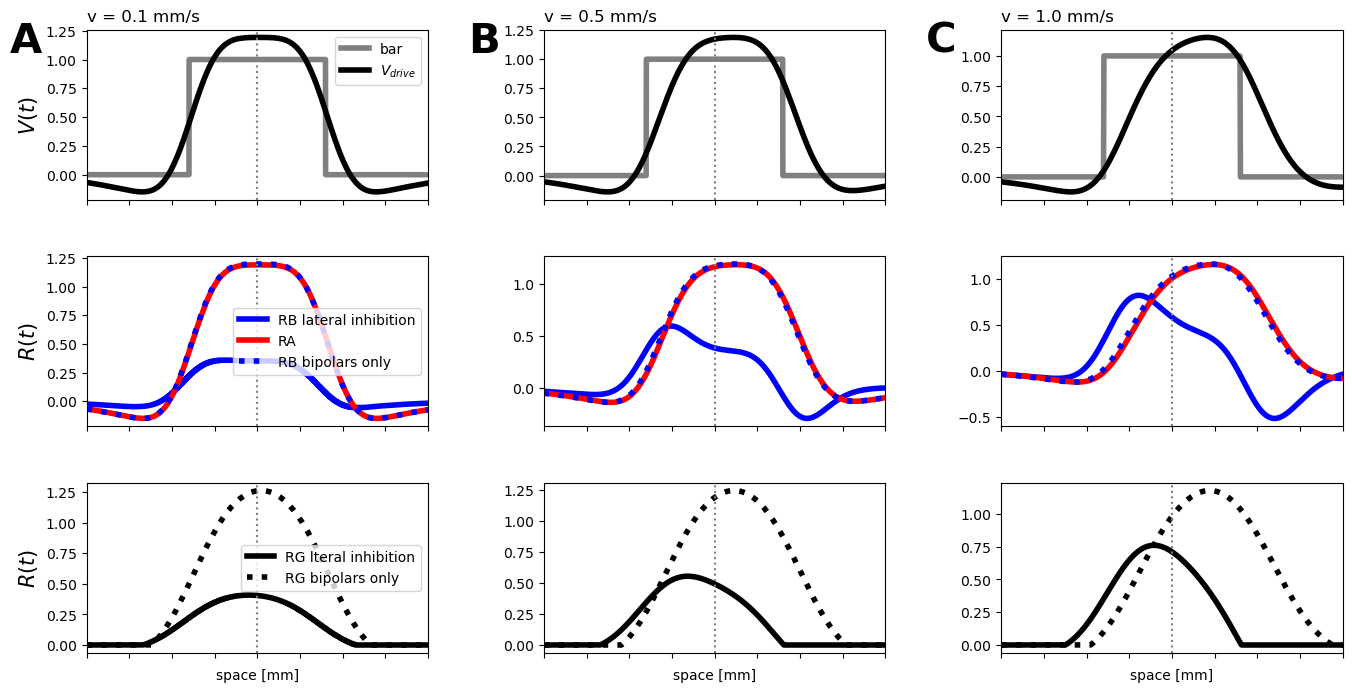

In [16]:


#initialize figure
nrows = 13
ncols = 3

fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)
#fig.tight_layout()


#TODO adjustment
fig.subplots_adjust(top=0.945,
bottom=0.06,
left=0.105,
right=0.89,
hspace=1.0,
wspace=0.34)


#TODO remove axis

#TODO fontsizes


cbar = 'grey'
c1 = 'k'
LAB = ['A', 'B', 'C']
net = nets_list[1]
net_pool = nets_list[0]
for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[0:2,x])


        ax2 = fig.add_subplot(gs[2:4,x], sharex = ax)
    

        ax3 = fig.add_subplot(gs[4:6,x], sharex = ax)
    

    else:
        ax = fig.add_subplot(gs[0:2,x])
        ax2 = fig.add_subplot(gs[2:4,x], sharex = ax)
        ax3 = fig.add_subplot(gs[4:6,x], sharex = ax)



    ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, LAB[x], transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

    ax.set_xlim(-0.4,0.4)
  
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    xdata =(data['times'][i]- data['tps_rf_mid'][i])*s 

    ax.plot(xdata,data['bars'][i], label = f'bar', color = cbar, linewidth = lw)

    # plot drive 
    ax.plot(xdata,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$', color = c1, linewidth = lw)

    # plot RB
    ax2.plot(xdata,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB lateral inhibition', color = 'blue', linewidth = lw)
    ax2.plot(xdata,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red', linewidth = lw)
    ax2.plot(xdata,data[net_pool]['RB'][i]/np.max(data[net_pool]['RB'][-1]), label = f'RB bipolars only', color = 'blue', linestyle = ':', linewidth = lw)

    # plot RG
    ax3.plot(xdata,data[net]['RG'][i]/np.max(data[net]['RG'][-1]), label = f'RG lteral inhibition', color = 'k', linewidth = lw)
    ax3.plot(xdata,data[net_pool]['RG'][i]/np.max(data[net_pool]['RG'][-1]), linestyle = ':', label = f'RG bipolars only', color = 'k', linewidth = lw)
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')


    ax.axvline(0, color = cbar, linestyle = ':')
    ax2.axvline(0, color = cbar, linestyle = ':')
    ax3.axvline(0, color = cbar, linestyle = ':')
    ax.tick_params(labelsize = fontsize_ticks)
    ax2.tick_params(labelsize = fontsize_ticks)
    ax3.tick_params(labelsize = fontsize_ticks)
    
    ax.set_xticklabels([])
    ax2.set_xticklabels([])

    if i ==0 :
        ax.legend(fontsize = fontsize_legend)
        ax2.legend(fontsize = fontsize_legend)
        ax3.legend(fontsize = fontsize_legend)
        ax.set_ylabel('$V(t)$', fontsize = fontsize_labels)
        ax2.set_ylabel('$R(t)$', fontsize = fontsize_labels)
        ax3.set_ylabel('$R(t)$', fontsize = fontsize_labels)

    ax3.set_xlabel('space [mm]')

# fig.suptitle(f'{net}')

fig.savefig('../svg/3_FB_speedscaling.svg', format='svg')
fig.savefig('../png/3_FB_speedscaling.png', format='png')






In [ ]:
%matplotlib qt